In [1]:
from __future__ import print_function

In [80]:
import os.path
import pandas as pd
import numpy as np
from sklearn import metrics
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Reading the files and storing them into pandas dataframe
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [4]:
# Taking a look at the data... 
print("Size of orders:", orders.shape)
print("Size of order_products_prior:", order_products_prior.shape)
print("Size of order_products_train:", order_products_train.shape)

Size of orders: (90563, 7)
Size of order_products_prior: (32434489, 4)
Size of order_products_train: (1384617, 4)


In [5]:
print(orders.head())
print(order_products_train.tail())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
         order_id  product_id  add_to_cart_order  reordered
1384612   3421063       14233                  3          1
1384613   3421063       35548                  4          1
1384614   3421070       35951                  1          1
1384615   3421070       16953                  2          1
1384616   3421070        4724                  3          1


In [6]:
# Checking what data types are in each df
aisles.dtypes

aisle_id     int64
aisle       object
dtype: object

In [7]:
departments.dtypes

department_id     int64
department       object
dtype: object

In [8]:
order_products_prior.dtypes

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

In [9]:
order_products_train.dtypes

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

In [10]:
orders.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [11]:
products.dtypes

product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object

In [12]:
# ~200,000 users making ~3.4M orders from Instacart
print("# Unique:", orders.nunique())

# Unique: order_id                  90563
user_id                    5484
eval_set                      3
order_number                100
order_dow                     7
order_hour_of_day            24
days_since_prior_order       31
dtype: int64


In [13]:
print("# Unique:", order_products_prior.nunique())

# Unique: order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64


In [14]:
print("# Unique:", order_products_train.nunique())

# Unique: order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64


In [15]:
''' 
There are three categories in the "orders" df to distinguish where data is separated into "order_products_prior" and 
"order_products_train"
'''
print(orders.eval_set.unique())

['prior' 'train' 'test']


In [16]:
# Sanity check of the counts
orders.eval_set.value_counts()

prior    85079
train     3490
test      1994
Name: eval_set, dtype: int64

In [17]:
# Let's take a look at a customer by applying a mask
customermask = orders.user_id == 10
customerorders = orders[customermask]
print(customerorders)

    order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
83   1224907       10    prior             1          2                 14   
84     68288       10    prior             2          5                 15   
85   2115522       10    prior             3          3                 19   
86     83395       10    prior             4          3                 15   
87   1353310       10    prior             5          5                 20   
88   1822501       10    train             6          0                 19   

    days_since_prior_order  
83                     NaN  
84                    30.0  
85                    12.0  
86                    14.0  
87                    23.0  
88                    30.0  


In [18]:
'''
Let's take a look at a specific customer and the order_id(s) in order_products_prior by applying a mask. 
It looks like the first order by the customer will have "days_since_prior_order"=NaN and the last line will be either "train" or "test"
'''
orderIDmask = order_products_prior.order_id == 2115522
specificOrder = order_products_prior[orderIDmask]
print(specificOrder)

orderIDmasktrain = order_products_train.order_id == 1822501
specificOrdertrain = order_products_train[orderIDmasktrain]
print(specificOrdertrain)

          order_id  product_id  add_to_cart_order  reordered
20057732   2115522       47380                  1          1
20057733   2115522        5769                  2          0
20057734   2115522       13629                  3          0
20057735   2115522       40706                  4          0
20057736   2115522       45007                  5          0
20057737   2115522       44359                  6          0
20057738   2115522       17794                  7          0
20057739   2115522       19678                  8          0
20057740   2115522        5450                  9          0
20057741   2115522       26940                 10          0
20057742   2115522       48775                 11          0
20057743   2115522       21174                 12          0
20057744   2115522       18656                 13          0
20057745   2115522       30305                 14          0
20057746   2115522       37687                 15          0
20057747   2115522      

In [19]:
# Combining Prior and Train df
productPriorTrain = pd.concat((order_products_prior, order_products_train), axis = 0)

In [20]:
# Merging with orders df
ordersAll = pd.merge(orders, productPriorTrain, how='inner', on="order_id")

In [21]:
ordersAll.shape

(884069, 10)

In [22]:
# What are the features I can work with in the test eval_set
testmask = ordersAll.order_id ==414
ordersProdtest = ordersAll[testmask]
print(ordersProdtest)

Empty DataFrame
Columns: [order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order, product_id, add_to_cart_order, reordered]
Index: []


In [23]:
ordersAll.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [24]:
# Let's take a look to see which department gets the most reordered, merge on product_id
ordersAllProduct = pd.merge(ordersAll, products, on="product_id")

In [25]:
ordersAllProduct.shape

(884069, 13)

In [26]:
ordersAllDept = pd.merge(ordersAllProduct, departments, on="department_id")

In [27]:
# Looks good so far...
ordersAllDept.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,beverages


In [28]:
ordersAllDA = pd.merge(ordersAllDept, aisles, on="aisle_id")

In [29]:
ordersAllDA.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,beverages,soft drinks
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,beverages,soft drinks
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,beverages,soft drinks
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,beverages,soft drinks


In [99]:
#Dropping NaN rows
ordersAllDA = ordersAllDA.dropna()

In [102]:
# not having great correlation with anything specific
ordersAllDA.corr()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
order_id,1.000000,0.016972,-0.000999,0.003748,0.001250,-0.000440,0.002411,0.000339,0.000684,0.000152,-0.000568
user_id,0.016972,1.000000,0.039885,0.011067,-0.013624,-0.026132,-0.001811,0.014629,0.013641,-0.000967,0.010411
order_number,-0.000999,0.039885,1.000000,0.013441,-0.044319,-0.364697,-0.001184,-0.006852,0.250800,-0.003107,0.006011
order_dow,0.003748,0.011067,0.013441,1.000000,-0.003809,-0.025162,-0.000489,-0.012001,-0.014874,-0.001989,0.004015
order_hour_of_day,0.001250,-0.013624,-0.044319,-0.003809,1.000000,0.005890,0.001439,-0.018523,-0.019757,-0.000224,-0.010587
days_since_prior_order,-0.000440,-0.026132,-0.364697,-0.025162,0.005890,1.000000,-0.001376,0.050977,-0.139167,0.009563,-0.001946
product_id,0.002411,-0.001811,-0.001184,-0.000489,0.001439,-0.001376,1.000000,0.004017,0.005706,0.002987,-0.028720
add_to_cart_order,0.000339,0.014629,-0.006852,-0.012001,-0.018523,0.050977,0.004017,1.000000,-0.138744,0.010800,0.034709
reordered,0.000684,0.013641,0.250800,-0.014874,-0.019757,-0.139167,0.005706,-0.138744,1.000000,0.001125,-0.040043
aisle_id,0.000152,-0.000967,-0.003107,-0.001989,-0.000224,0.009563,0.002987,0.010800,0.001125,1.000000,0.053704


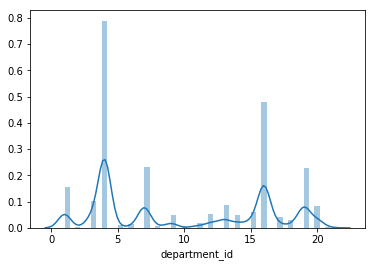

In [103]:
# Plot graph of which department gets most reordered
reorderMask = ordersAllDA.reordered == 1
reorderProducts = ordersAllDA[reorderMask]
sns.distplot(reorderProducts["department_id"])
# Looks like Department 4 is the most reordered department. Department 4 is produce. 

In [108]:
#Getting the features and target
feature_col = ["user_id", "order_dow", "order_hour_of_day", "days_since_prior_order", "product_id", "department_id","aisle_id"]
orders_features = ordersAllDA[feature_col]
orders_target = ordersAllDA["reordered"]

In [113]:
# linear regression using 20-fold cross validation 
X = StandardScaler().fit_transform(orders_features)
y = ordersAllDA["reordered"]

lr = LinearRegression()
mean_squared_errors = np.abs(cross_val_score(lr, X, y, cv=20, scoring='neg_mean_squared_error'))
root_mean_squared_errors = list(map(np.sqrt, mean_squared_errors))
print("20-fold mean RMSE: ", np.mean(root_mean_squared_errors))

20-fold mean RMSE:  0.479517052044


In [114]:
# logistic regression using 20-fold cross validation 
X = StandardScaler().fit_transform(orders_features)
y = ordersAllDA["reordered"]

logr = LogisticRegression()
mean_squared_errors = np.abs(cross_val_score(logr, X, y, cv=20, scoring='neg_mean_squared_error'))
root_mean_squared_errors = list(map(np.sqrt, mean_squared_errors))
print("20-fold mean RMSE: ", np.mean(root_mean_squared_errors))

20-fold mean RMSE:  0.620819524183


In [116]:
coeffs = LinearRegression().fit(X,y).coef_
coeff_df = pd.DataFrame(list(zip(orders_features,np.abs(coeffs))), columns=["features","betas"])
coeff_df.sort_values("betas", ascending=False, inplace=True)
coeff_df

,features,betas
3,days_since_prior_order,0.067325
5,department_id,0.019650
2,order_hour_of_day,0.009324
1,order_dow,0.008886
0,user_id,0.005012
6,aisle_id,0.002221
4,product_id,0.002111


In [117]:
pf_3 = PolynomialFeatures(degree=3, interaction_only=True)
pf_3_data = pf_3.fit_transform(orders_features)[:, 1:]
print(pf_3_data.shape)

(829983L, 63L)


In [119]:
lr = LinearRegression()
absolute_errors = np.abs(cross_val_score(lr, pf_3_data, orders_features, cv=15))

In [120]:
rmses = list(map(np.sqrt, absolute_errors))
print("15-fold mean RMSE for degree-3 case: ", np.mean(rmses))

15-fold mean RMSE for degree-3 case:  1.0


In [125]:
# logistic regression with L1 penalty
feature = ["days_since_prior_order"]
X = ordersAllDA[feature]
y = ordersAllDA["reordered"]
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(X, y)
outcome_predict = log.predict(X) 